In [1]:
import numpy as np
from scipy import linalg as sp_linalg
import matplotlib.pyplot as plt

In [2]:
# Constants
beta = 1.0 # inverse temperature 
dt_sim = 0.001
x0 = 0.0
tmax = 1000.0

In [3]:
def potential(x):
    return x**4/4 - x**2/2 + 0.2*x
def drift_fun(x):
    return -x**3 + x - 0.2
def integrate(x0, seed=1223):
    rng = np.random.default_rng(seed=seed)
    t = np.arange(0, tmax, dt_sim)
    Nt = len(t)
    x = np.zeros(Nt)
    x[0] = x0
    for i in range(1,Nt):
        x[i] = x[i-1] + drift_fun(x[i-1])*dt_sim + rng.standard_normal()*np.sqrt(2/beta)*np.sqrt(dt_sim)
    return t,x

In [4]:
t,x = integrate(x0)

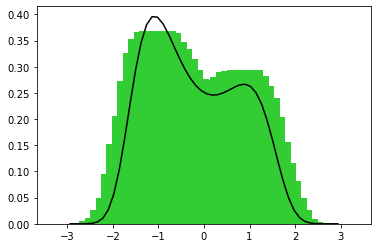

In [5]:
bin_edges = np.linspace(-3,3,51)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
hist_the = np.exp(-beta*potential(bin_centers))
hist_the *= 1.0/np.sum(hist_the * (bin_centers[1]-bin_centers[0]))
hist_emp,_ = np.histogram(x, bins=bin_edges, density=True)

fig,ax = plt.subplots()
ax.bar(bin_centers, hist_emp, color='limegreen')
ax.plot(bin_centers, hist_the, color='black')

# Now two-dimensional, still gradient system

In [6]:
# Constants
beta = 1.0 # inverse temperature 
dt_sim = 0.001
x0 = np.zeros(2)
tmax = 1000.0

In [7]:
def potential(x):
    return x[0]**4/4 - x[0]**2/2 + 0.2*x[0] + x[1]**2/2 
def drift_fun(x):
    return -np.array([x[0]**3-x[0]+0.2, x[1]])
def integrate(x0, seed=1223):
    rng = np.random.default_rng(seed=seed)
    sigma = np.sqrt(2/beta) * np.eye(2)
    t = np.arange(0, tmax, dt_sim)
    Nt = len(t)
    x = np.zeros((Nt,2))
    x[0] = x0
    for i in range(1,Nt):
        x[i] = x[i-1] + drift_fun(x[i-1])*dt_sim + sigma.dot(rng.standard_normal(size=2))*np.sqrt(dt_sim)
    return t,x

In [8]:
t,x = integrate(x0)

In [9]:
xe = np.linspace(-3,3,21)
ye = np.linspace(-3,3,21)
xc = (xe[:-1] + xe[1:])/2
yc = (ye[:-1] + ye[1:])/2
xye,yxe = np.meshgrid(xe,ye,indexing='ij')
xyc,yxc = np.meshgrid(xc,yc,indexing='ij')
hist_the = np.exp(-beta*potential(np.array([xyc,yxc])))
hist_the *= 1.0/np.sum(hist_the * (xe[1]-xe[0])*(ye[1]-ye[0]))

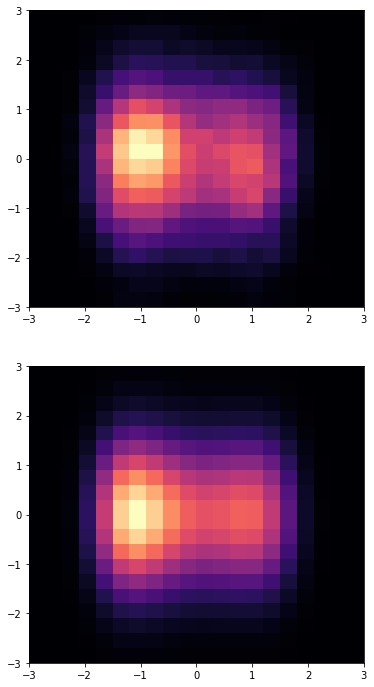

In [10]:
fig,ax = plt.subplots(nrows=2,figsize=(6,12))
ax[0].hist2d(x[:,0],x[:,1],bins=[xe,ye],cmap=plt.cm.magma,density=True)
ax[1].pcolormesh(xye,yxe,hist_the,cmap=plt.cm.magma)

# Now a multi-dimensional linear process

In [295]:
beta = 50.0 # inverse temperature 
dt_sim = 0.0002
x0 = np.zeros(2)
tmax = 400.0
mu = 0*np.array([7.0, 12.0])

In [296]:
# Make a harmonic oscillator for A
A = np.array([[0, 1],[-(2*np.pi/10.0)**2, -0.1]])

In [297]:
# compute the theoretical covariance matrix
sigma = np.sqrt(2/beta) * np.eye(2)
cov_the = sp_linalg.solve_sylvester(A, A.T, -2*sigma @ sigma.T)
cov_inv_the = np.linalg.inv(cov_the)

In [298]:
def drift_fun(x):
    return A @ (x - mu)
def integrate(x0, seed=1223):
    rng = np.random.default_rng(seed=seed)
    t = np.arange(0, tmax, dt_sim)
    Nt = len(t)
    x = np.zeros((Nt,2))
    x[0] = x0
    for i in range(1,Nt):
        x[i] = x[i-1] + drift_fun(x[i-1])*dt_sim + sigma.dot(rng.standard_normal(size=2))*np.sqrt(dt_sim)
    return t,x

In [299]:
t,x = integrate(x0)

In [300]:
xe = np.linspace(mu[0]-3,mu[0]+3,21)
ye = np.linspace(mu[1]-3,mu[1]+3,21)
xc = (xe[:-1] + xe[1:])/2
yc = (ye[:-1] + ye[1:])/2
xye,yxe = np.meshgrid(xe,ye,indexing='ij')
xyc,yxc = np.meshgrid(xc,yc,indexing='ij')
x_vec_c = np.array([xyc.flatten(), yxc.flatten()]).T
hist_the = np.exp(
    - np.sum(((x_vec_c-mu) @ cov_inv_the) * (x_vec_c-mu), axis=1)
).reshape((len(xc),len(yc)))
hist_the *= 1.0/np.sum(hist_the * (xe[1]-xe[0])*(ye[1]-ye[0]))

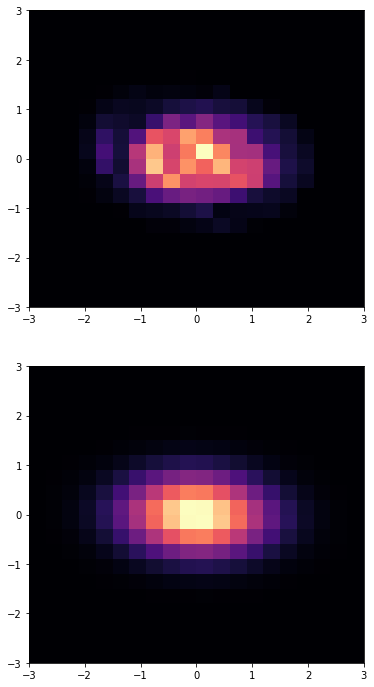

In [301]:
fig,ax = plt.subplots(nrows=2,figsize=(6,12))
ax[0].hist2d(x[:,0],x[:,1],bins=[xe,ye],cmap=plt.cm.magma,density=True)
ax[1].pcolormesh(xye,yxe,hist_the,cmap=plt.cm.magma)

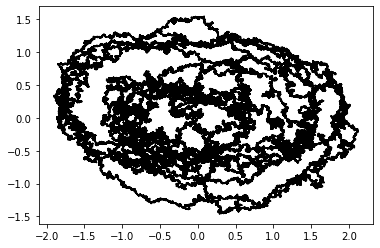

In [302]:
fig,ax = plt.subplots()
timin = len(t) - 500000
ax.plot(x[timin:,0],x[timin:,1],color='black')

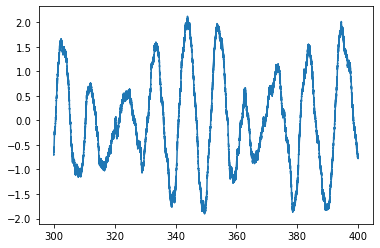

In [303]:
plt.plot(t[timin:],x[timin:,0])

# Linear inverse model

Can we fit the data above to a linear SDE without knowing the system? 

In [321]:
N = 100
Nt = len(t)
dt = t[1] - t[0]
rng = np.random.default_rng(seed=45)
lag_want = np.linspace(5, 50, 100)
lag_have = lag_want.copy()
Nlags = len(lag_want)
eval_fit = np.zeros((Nlags,2), dtype=complex)
eval_true = np.zeros((Nlags,2), dtype=complex)
for i_want in range(len(lag_want)):
    lag_idx = int(round(lag_want[i_want] / dt))
    lag_have[i_want] = t[lag_idx] - t[0]
    init_idx = rng.choice(np.arange(Nt-lag_idx), size=N, replace=False)
    X_init = x[init_idx]
    X_lag = x[init_idx + lag_idx]
    C_t0 = 1/N * X_lag.T @ X_init
    C_00 = 1/N * X_init.T @ X_init
    eAt_fit = C_t0 @ np.linalg.inv(C_00)
    eAt_true = sp_linalg.expm(A*lag_have[i_want])
    eval_fit[i_want] = np.linalg.eig(eAt_fit)[0]
    eval_true[i_want] = np.linalg.eig(eAt_true)[0]
    # TODO: for higher-dimensional systems, sort these first by real part and then by imaginary part
    order_fit = np.argsort(eval_fit[i_want].imag)
    order_true = np.argsort(eval_true[i_want].imag)
    eval_fit[i_want] = eval_fit[i_want][order_fit][::-1]
    eval_true[i_want] = eval_true[i_want][order_true][::-1]
    #eval_fit[i_want] = eAt_fit[1,:] 
    #eval_true[i_want] = eAt_true[1,:] 

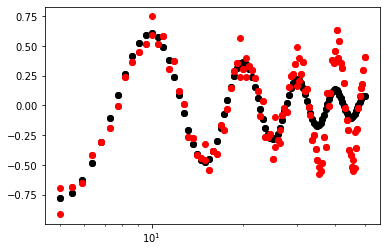

In [323]:
fig,ax = plt.subplots()
ax.scatter(lag_have, eval_true[:,1].real, color='black')
ax.scatter(lag_have, eval_true[:,0].real, color='black')
ax.scatter(lag_have, eval_fit[:,1].real, color='red')
ax.scatter(lag_have, eval_fit[:,0].real, color='red')
ax.set_xscale('log')

In [288]:
eval_fit

array([[ 0.97049075+0.j,  0.35188114+0.j],
       [ 0.97007294+0.j,  0.06693763+0.j],
       [ 0.97257948+0.j, -0.21557371+0.j],
       [ 0.97049804+0.j, -0.46257973+0.j],
       [ 0.97092727+0.j, -0.65496435+0.j],
       [ 0.97297426+0.j, -0.76292635+0.j],
       [ 0.97233107+0.j, -0.78952132+0.j],
       [ 0.97489224+0.j, -0.72718104+0.j],
       [ 0.9748681 +0.j, -0.59222874+0.j],
       [ 0.97730503+0.j, -0.39325059+0.j],
       [ 0.97858857+0.j, -0.18391932+0.j],
       [ 0.9788825 +0.j,  0.06967285+0.j],
       [ 0.98351274+0.j,  0.27077049+0.j],
       [ 0.9881324 +0.j,  0.44216763+0.j],
       [ 0.99282506+0.j,  0.564336  +0.j],
       [ 0.99491155+0.j,  0.62216303+0.j],
       [ 0.99341726+0.j,  0.6120199 +0.j],
       [ 0.9892231 +0.j,  0.53849775+0.j],
       [ 0.98520971+0.j,  0.40509367+0.j],
       [ 0.98290052+0.j,  0.25274472+0.j]])

In [246]:
np.linalg.eig(A)

(array([-0.25+0.57644096j, -0.25-0.57644096j]),
 array([[ 0.84673302+0.j        ,  0.84673302-0.j        ],
        [-0.21168325+0.48809159j, -0.21168325-0.48809159j]]))

In [88]:
eAt_true

array([[ 0.30817663,  0.31640816],
       [-0.05980114,  0.07087051]])

In [74]:
lag_idx*dt_sim

2.0

In [89]:
A

array([[-0.5   ,  0.8   ],
       [-0.1512, -1.1   ]])